In [1]:
! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=95f46983eac9c695eaa44db0e9e0b843367d39acd36796fcee24e32a459a6075
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=be2df0d4469600a30218ef28b203016d7bf166720a3e161e84738c20aa9866a6
  Stored in directory: /root/.cache/pip/w

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import segmentation_models_pytorch as smp
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, lraspp_mobilenet_v3_large, deeplabv3_resnet101

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
#CLASSES = ["background", "skin", "nose", "right_eye", "left_eye", "right_brow", "left_brow", "right_ear", "left_ear", "mouth_interior", "top_lip", "bottom_lip", "neck", "hair", "beard", "clothing", "glasses", "headwear", "facewear"]
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 12

"""
aux_params=dict(
    pooling='avg',       # one of 'avg', 'max'
    classes=num_classes, 
    activation = None
)
"""

#DEEPLABV3+

deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    #aux_params=aux_params
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [4]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row (Original Image: Ground Truth : Predicted)
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        if name == "original_image":
          #print(image.shape)
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
        else:
          #print(image.shape)
          # get title from the parameter names
          plt.title(name.replace('_',' ').title(), fontsize=20)
          plt.imshow(image)
    plt.show()

#Function to reverse one-hot-encode an image
def reverse_one_hot(image):
    #argmax to return the indices of the maximum values along an axis. 
    x = np.argmax(image, axis = -3)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.numpy().astype(int)]

    return x

In [6]:
#import torchvision.transforms as T
#import torchvision.transforms.functional as F
import albumentations as albu
import random
import scipy
import torch
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import re

SIZEX = 128
SIZEY = 128

rgb_vals = [0,1,2,3,4,5,6,7,8,9,10,11,12]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, mix_img_dir, mix_mask_dir, mix_coords, preprocessing=None, classes=None,augmentation=None, mode="train"):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)
    self.mix_ids = os.listdir(mix_img_dir)

    if mode == "train":
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][200::]
      self.masks_fps = [os.path.join(masks_dir, mask_id.replace("_seg","")) for mask_id in self.image_ids][200::]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace("_seg.png", "_ldmks.txt")) for coords_id in self.image_ids][200::]
    else:
      self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids][:200]
      self.masks_fps = [os.path.join(masks_dir, mask_id.replace("_seg","")) for mask_id in self.image_ids][:200]
      self.coords_fps = [os.path.join(coords_dir, coords_id.replace("_seg.png", "_ldmks.txt")) for coords_id in self.image_ids][:200]

    if mode == "train":
      self.images_fps = self.images_fps + [os.path.join(mix_mask_dir, mask_id.replace("jpg","png")) for mask_id in self.mix_ids][:800:]
      self.masks_fps = self.masks_fps + [os.path.join(mix_img_dir, image_id) for image_id in self.mix_ids][:800:]
      self.coords_fps = self.coords_fps + [os.path.join(mix_coords, coords_id.replace("jpg", "txt")) for coords_id in self.mix_ids][:800:]
    else:
      self.images_fps = self.images_fps + [os.path.join(mix_mask_dir, mask_id.replace("jpg","png")) for mask_id in self.mix_ids][800:1000:]
      self.masks_fps = self.masks_fps + [os.path.join(mix_img_dir, image_id) for image_id in self.mix_ids][800:1000:]
      self.coords_fps = self.coords_fps + [os.path.join(mix_coords, coords_id.replace("jpg", "txt")) for coords_id in self.mix_ids][800:1000]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.masks_fps[i])

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.images_fps[i],0)

    #print(self.masks_fps[i])
    #print(self.images_fps[i])

    # crop to center face
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    with open(self.coords_fps[i], 'rb') as f:

      contents = str(f.read()).split("\\n")
      #print(contents)
      contents = [[int(float(single.replace("\\r", "").
                             replace("'", "").replace("b", "").replace("\\x1a", "")
                             )) for single in pair.split(" ")] for pair in contents[2:-2]]
      #print(contents)

      #contents = np.array(contents)
      for pair in contents:
        #plt.scatter((pair[0]), (pair[1]), color="red")

        if (pair[0]) < smallest_x:
          smallest_x = (pair[0])
        
        if (pair[0]) > biggest_x:
          biggest_x = (pair[0])

        if (pair[1]) < smallest_y:
          smallest_y = (pair[1])
        
        if (pair[1]) > biggest_y:
          biggest_y = (pair[1])


      crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

      image = image[smallest_y: biggest_y, smallest_x:biggest_x]
      mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]

    mask = cv2.resize(mask, (SIZEY, SIZEY))
    image = cv2.resize(image, (SIZEY, SIZEY))
    mask = np.expand_dims(mask,2)

    # smooth mask
    # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    # Rectify
    mask[mask > 10] = 11

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 12).permute(0,3,1,2).float()

    return (image, one_hot_Y.squeeze(0))


train_y_path = "/content/drive/MyDrive/wood_img"
train_x_path = "/content/drive/MyDrive/wood_mask"
train_coords_path = "/content/drive/MyDrive/wood_coords"

train_x_path2 = "/content/drive/MyDrive/helenstar_release/2/LaPa/train/images"
train_y_path2 = "/content/drive/MyDrive/helenstar_release/2/LaPa/train/labels"
train_coords_path2="/content/drive/MyDrive/helenstar_release/2/LaPa/train/landmarks"

train_ds = MyDataSet(train_y_path, 
                     train_x_path, 
                     train_coords_path, 
                     train_x_path2,
                     train_y_path2,
                     train_coords_path2,
                     preprocessing=get_preprocessing(preprocessing_fn),
                     augmentation=get_training_augmentation(), 
                     mode="train")

val_ds = MyDataSet(train_y_path,
                   train_x_path,
                   train_coords_path,
                   train_x_path2,
                   train_y_path2,
                   train_coords_path2,
                   preprocessing=get_preprocessing(preprocessing_fn),
                   augmentation=get_validation_augmentation(), 
                   mode="val")

image_vis, gt_mask = train_ds[20]

1600
400
0 : (3, 128, 128) torch.Size([12, 128, 128])


<ipython-input-22-93c5ca223edb>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


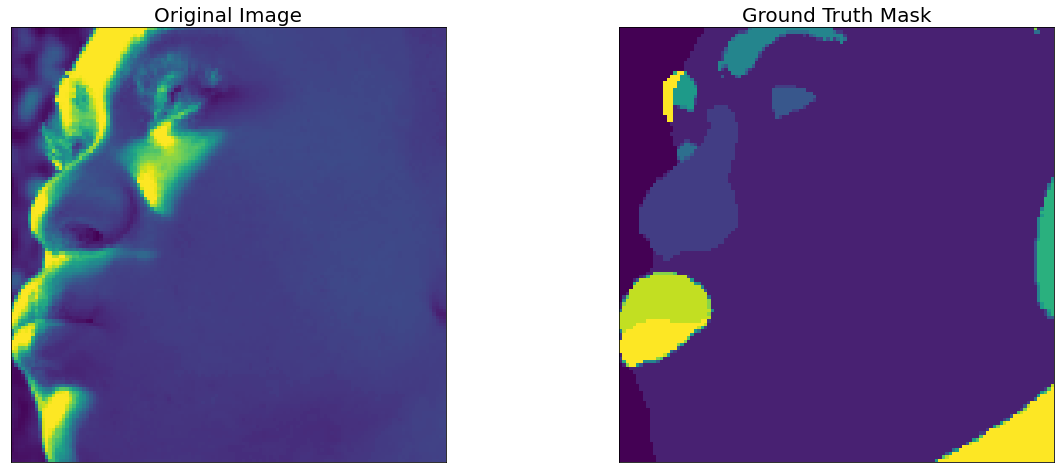

1 : (3, 128, 128) torch.Size([12, 128, 128])


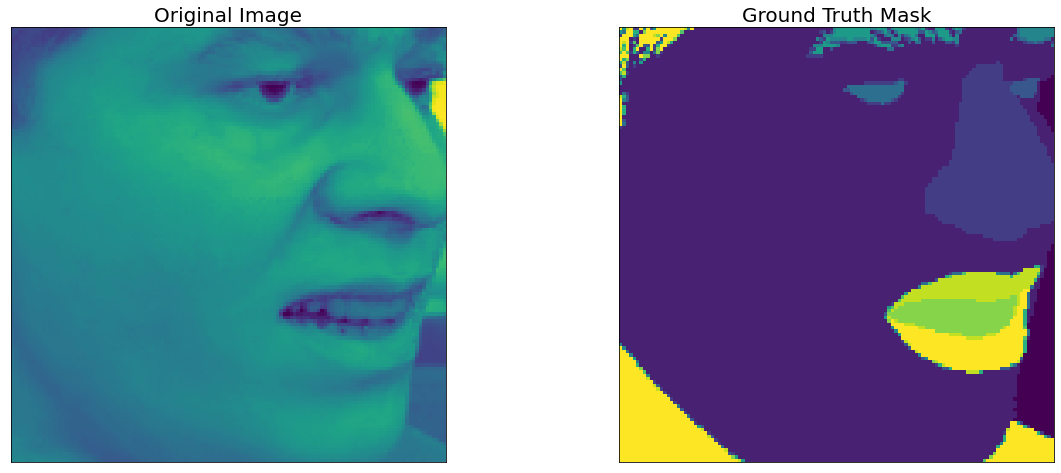

2 : (3, 128, 128) torch.Size([12, 128, 128])


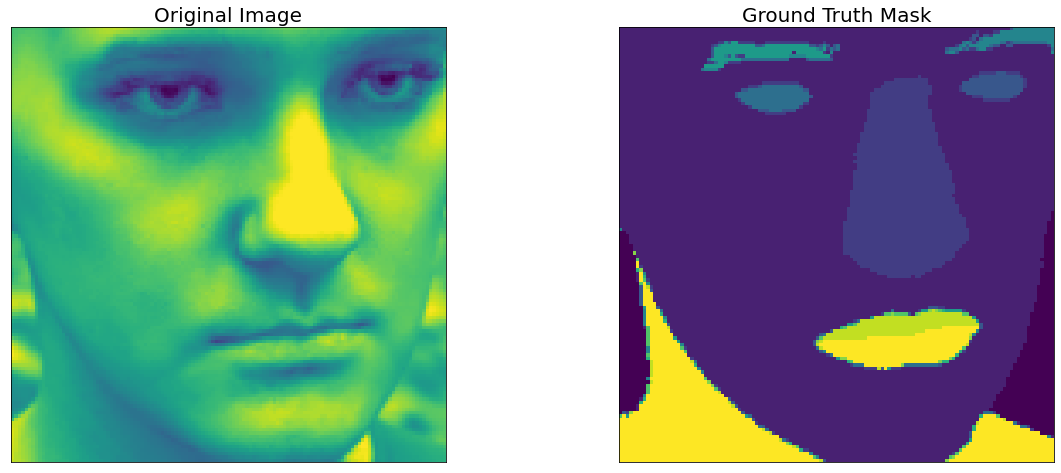

In [22]:
from matplotlib import pyplot as plt

print(len(train_ds))
print(len(val_ds))

for x in range(3):

  image_vis, gt_mask = val_ds[x+6]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

  visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

#np.unique(image_vis)

### Data Loader

In [23]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=12)
valid_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=12)

print(len(train_loader))

25


In [11]:
#image_vis, gt_mask = next(iter(train_loader))
#print(image_vis.shape)
#print(gt_mask.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 12, 128, 128])


### (DataLoader) Sanity check

TRAIN:
VAL:
0


<ipython-input-12-5030cb27a09c>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


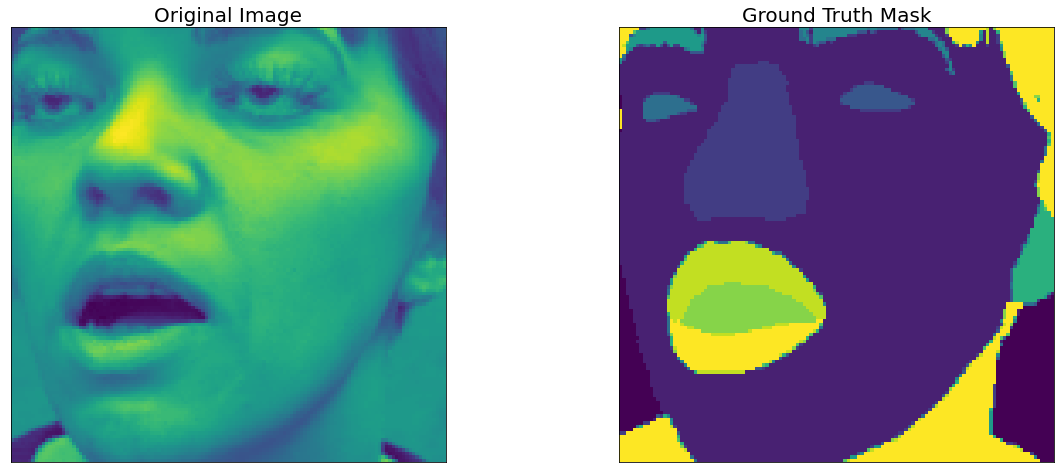

1


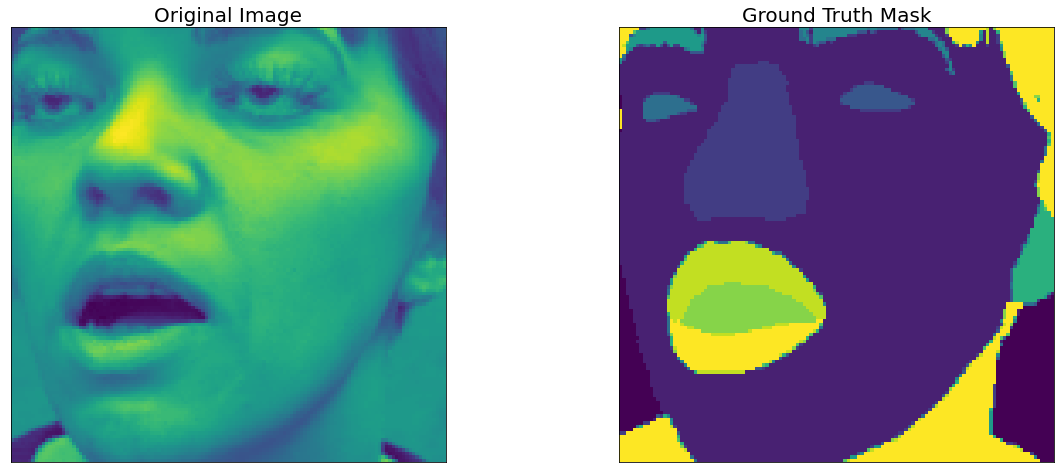

2


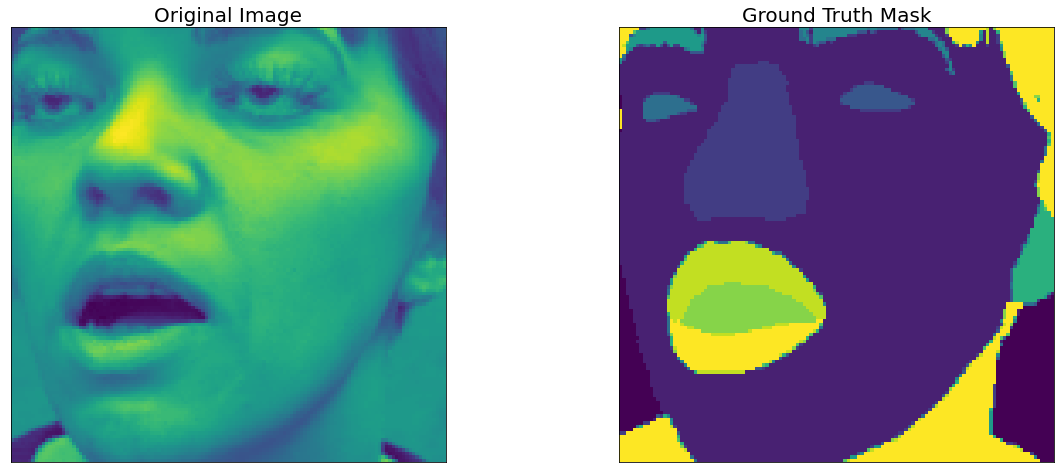

In [12]:
print("TRAIN:")
for x in range(0):

    image_vis, gt_mask = next(iter(train_loader))
    print(x)

    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    
    visualize(
        original_image = image_vis[0,::][0,::],
        ground_truth_mask = gt_mask[0,::]
    )
print("VAL:")
for x in range(3):

    image_vis, gt_mask = next(iter(valid_loader))
    print(x)

    gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)

    visualize(
        original_image = image_vis[0,::][0,::],
        ground_truth_mask = gt_mask[0,::]
    )

## Initialise Models

[link text](https:// [link text](https://))### Hyper Parameters

In [13]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing

weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights[11] = 0.0 #ignore index
normedWeights

tensor([0.9672, 0.3715, 0.9067, 0.9891, 0.9903, 0.9889, 0.9906, 0.9955, 0.9970,
        0.9863, 0.9783, 0.0000])

In [14]:
from segmentation_models_pytorch import utils
import os

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set device: `cuda` or `cpu`
#"cuda" if torch.cuda.is_available() else
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loss = smp.utils.losses.BCELoss()
#loss = FocalLoss("multilabel", alpha=0.25, gamma=4)
#weights = torch.tensor([0.7526, 0.4953, 0.9898, 0.9910, 0.9942, 0.9942, 0.9579, 0.9940, 0.9931,
#        0.9895, 0.8484])

#loss = SoftBCEWithLogitsLoss(pos_weight=normedWeights)
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]


## Train Model

In [15]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    #optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)
            #lr_scheduler.step()

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            v_ious.append(valid_logs['iou_score'])
            t_ious.append(train_logs['iou_score'])
            
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


In [16]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 16.1 MB/s eta 0:00:00


### Function to view train model precitions

In [28]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        pred_mask = model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan()
          #print(f1)
          f1s.append(np.array(f1))

        if idx == 10:
          visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

In [18]:
from torchvision.utils import save_image
from PIL import Image



def save_predictions(model, ds):

  xs = []
  ys = []

  #predict
  for idx in range(len(ds)):

      # Pop image from DS
      image, gt_mask = ds[idx]
      image_vis = image
      image_vis = np.transpose(image_vis,(1,2,0))
      
      # Reshape
      x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
      # Predict test image
      pred_mask = model(x_tensor)
      # Reshape
      pred_mask = pred_mask.detach().squeeze().cpu()

      print("saving", idx, "/", len(ds))

      # Save Predictions for use in Label Adapter
      xs.append(pred_mask)

      ys.append(gt_mask)
      
  return xs, ys

#save_predictions(model, val_ds)

# Predict with Deeplabv3+

In [ ]:
train_model(unet, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/mix/unet.pth", 50)
train_model(fcn, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/mix/fcn.pth", 50)
train_model(mobile, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/mix/mobile.pth", 50)
train_model(deeplab, train_loader, valid_loader, "/content/drive/MyDrive/FRESH/mix/deeplab.pth", 50)

### Load and view model predictions

<ipython-input-28-eabccd939b7e>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


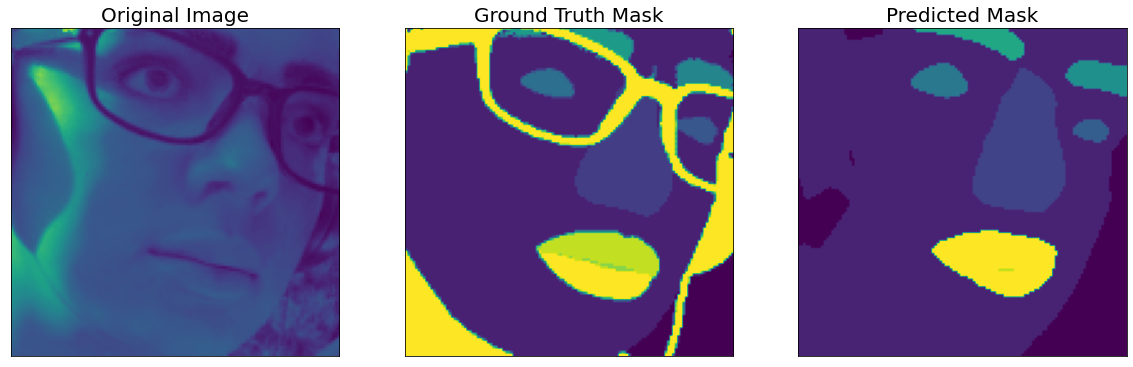

Dataset MIoU =  0.4790527479024604
Dataset F1 =  [0.68075484 0.9165456  0.7591927  0.5800804  0.5914669  0.5874734
 0.7242844  0.4768111  0.23906346 0.58296674 0.61186975 0.0999999 ]
Dataset F1 av =  0.57087576


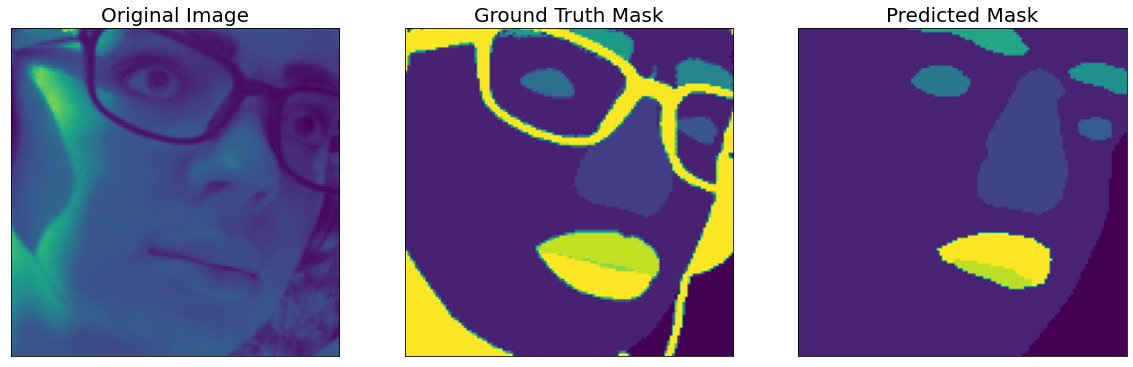

Dataset MIoU =  0.4678042562538758
Dataset F1 =  [0.7050947  0.9092657  0.7359723  0.5501683  0.5795785  0.5632332
 0.69631934 0.47346342 0.24733926 0.5311264  0.6454207  0.0999999 ]
Dataset F1 av =  0.56141514


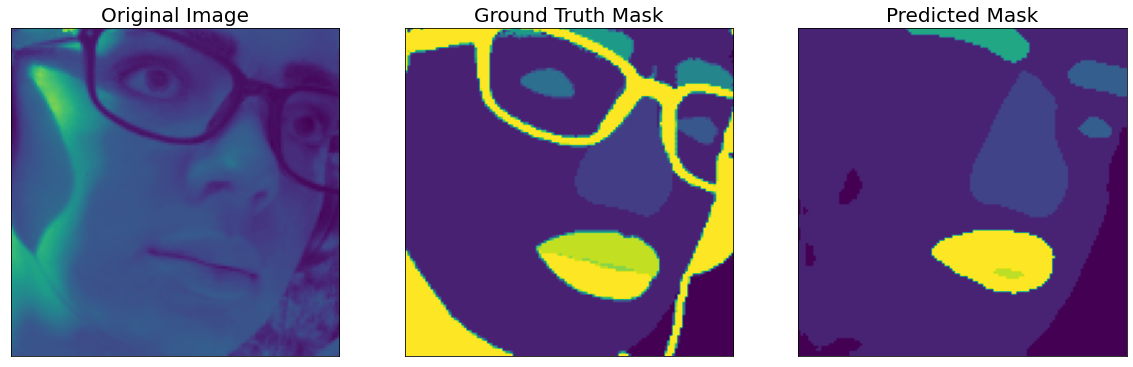

Dataset MIoU =  0.38811217081733046
Dataset F1 =  [0.68603116 0.91376394 0.74480486 0.43628365 0.0999999  0.10000501
 0.7124417  0.4705563  0.27948853 0.56304294 0.611735   0.0999999 ]
Dataset F1 av =  0.47651276


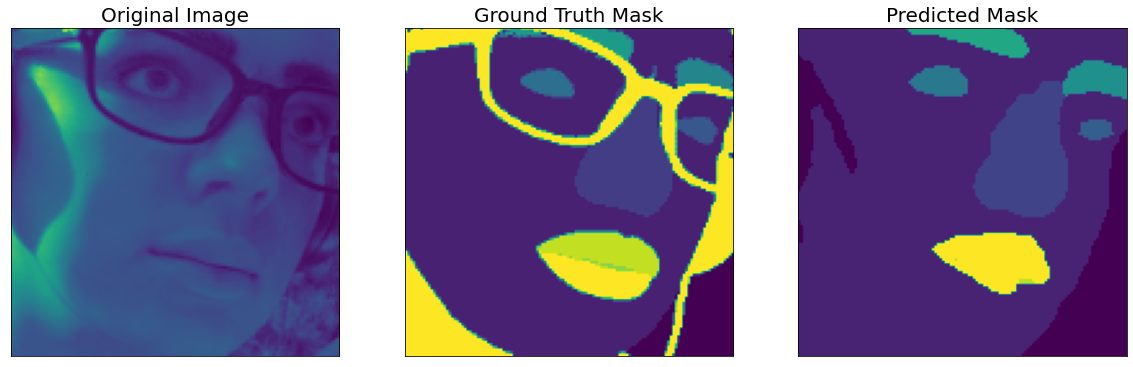

Dataset MIoU =  0.45833131226245316
Dataset F1 =  [0.6755761  0.9124104  0.7357205  0.54461986 0.571385   0.5541495
 0.6946165  0.4527815  0.23851798 0.5322725  0.617541   0.0999999 ]
Dataset F1 av =  0.55246586


In [30]:
model = torch.load("/content/drive/MyDrive/FRESH/mix/unet.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

model = torch.load("/content/drive/MyDrive/FRESH/mix/fcn.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

model = torch.load("/content/drive/MyDrive/FRESH/mix/mobile.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

model = torch.load("/content/drive/MyDrive/FRESH/mix/deeplab.pth", map_location=DEVICE)
view_predictions(model,val_ds, num_classes)

# label adapter

In [31]:
xs, ys = save_predictions(model, train_ds)

saving 0 / 1600
saving 1 / 1600
saving 2 / 1600
saving 3 / 1600
saving 4 / 1600
saving 5 / 1600
saving 6 / 1600
saving 7 / 1600
saving 8 / 1600
saving 9 / 1600
saving 10 / 1600
saving 11 / 1600
saving 12 / 1600
saving 13 / 1600
saving 14 / 1600
saving 15 / 1600
saving 16 / 1600
saving 17 / 1600
saving 18 / 1600
saving 19 / 1600
saving 20 / 1600
saving 21 / 1600
saving 22 / 1600
saving 23 / 1600
saving 24 / 1600
saving 25 / 1600
saving 26 / 1600
saving 27 / 1600
saving 28 / 1600
saving 29 / 1600
saving 30 / 1600
saving 31 / 1600
saving 32 / 1600
saving 33 / 1600
saving 34 / 1600
saving 35 / 1600
saving 36 / 1600
saving 37 / 1600
saving 38 / 1600
saving 39 / 1600
saving 40 / 1600
saving 41 / 1600
saving 42 / 1600
saving 43 / 1600
saving 44 / 1600
saving 45 / 1600
saving 46 / 1600
saving 47 / 1600
saving 48 / 1600
saving 49 / 1600
saving 50 / 1600
saving 51 / 1600
saving 52 / 1600
saving 53 / 1600
saving 54 / 1600
saving 55 / 1600
saving 56 / 1600
saving 57 / 1600
saving 58 / 1600
saving 

In [ ]:
len(xs)

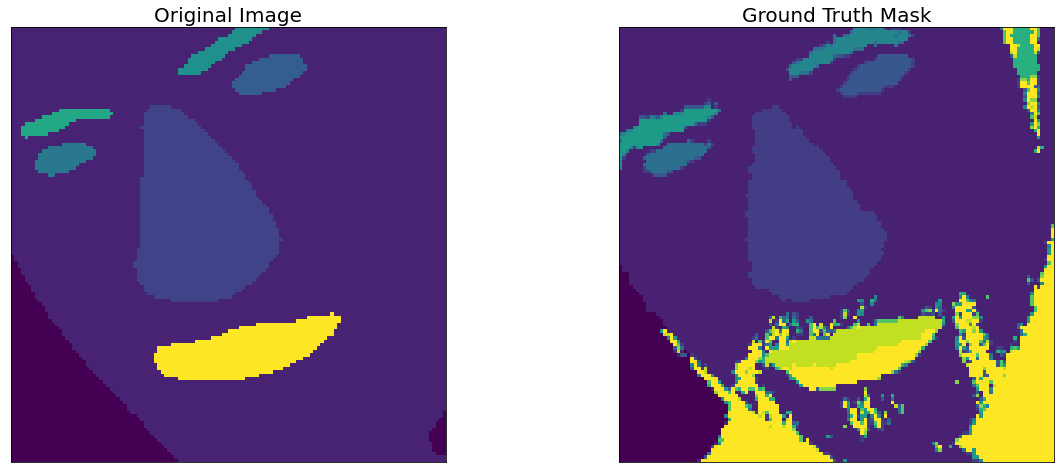

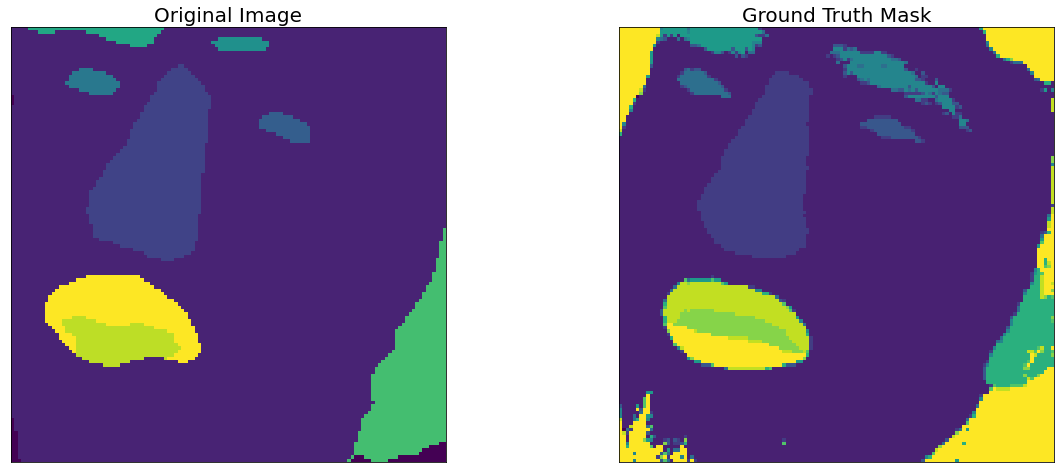

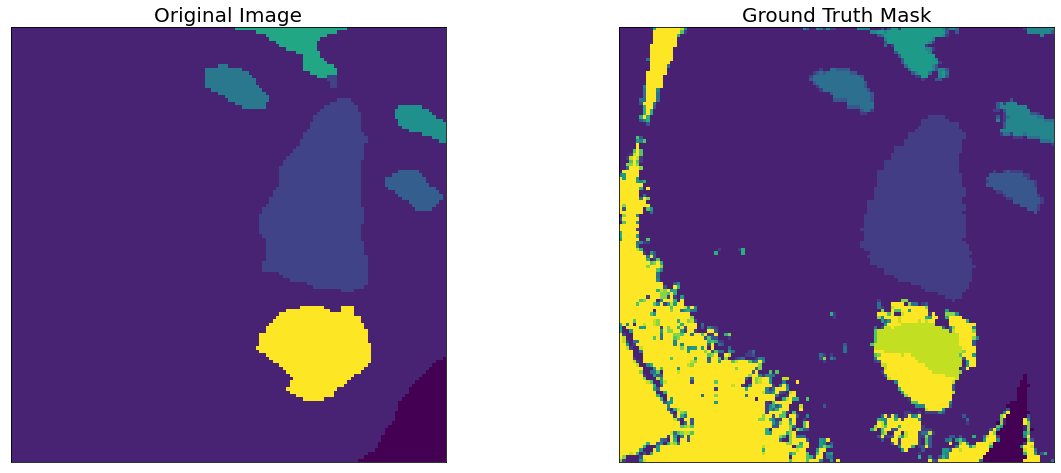

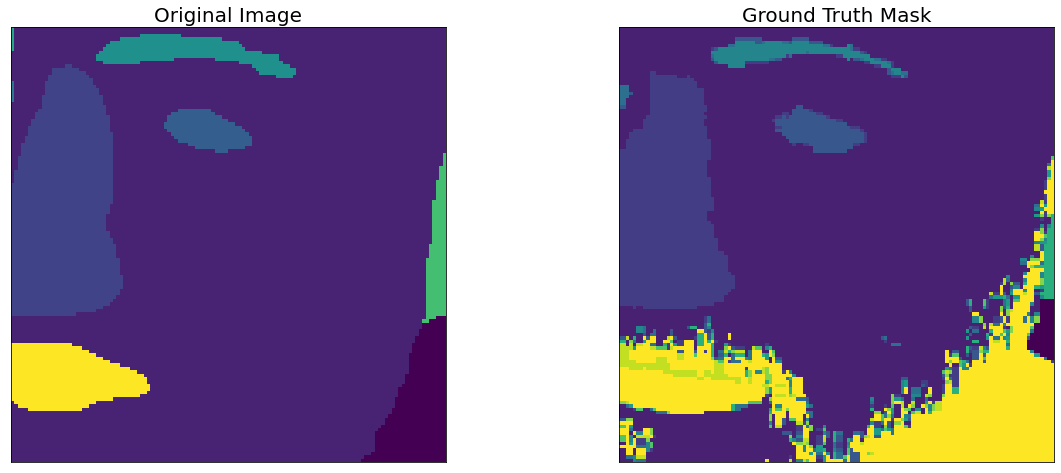

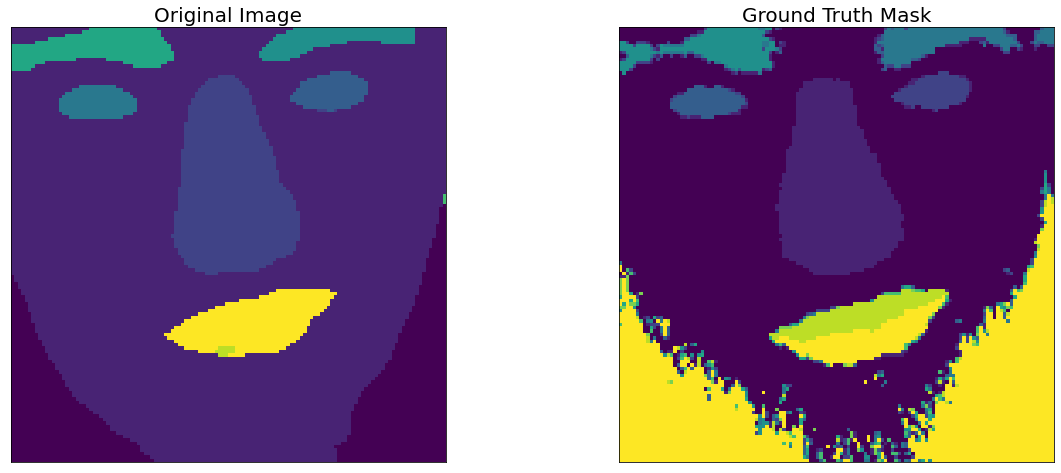

In [32]:
for x in range(5):
  visualize(
      original_image = colour_code_segmentation(reverse_one_hot(xs[x]), rgb_vals),
      ground_truth_mask = colour_code_segmentation(reverse_one_hot(ys[x]), rgb_vals),
      #ground_truth_mask = colour_code_segmentation(reverse_one_hot(ys[x]), rgb_vals)
  )


In [33]:
X2 = torch.stack(xs)
Y2 = torch.stack(ys)
print(X2.shape)
print(Y2.shape)

torch.Size([1600, 12, 128, 128])
torch.Size([1600, 12, 128, 128])


In [34]:
Y2 = Y2.float()
X2 = X2.float()
Y2.dtype

torch.float32

In [35]:
from sklearn.model_selection import train_test_split
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, shuffle=True)

print(x_train2.shape)
print(y_train2.shape)


#X = X.numpy().reindex(np.random.permutation(X.index))
#one_hot_Y = one_hot_Y.numpy().reindex(np.random.permutation(one_hot_Y.index))

torch.Size([1280, 12, 128, 128])
torch.Size([1280, 12, 128, 128])


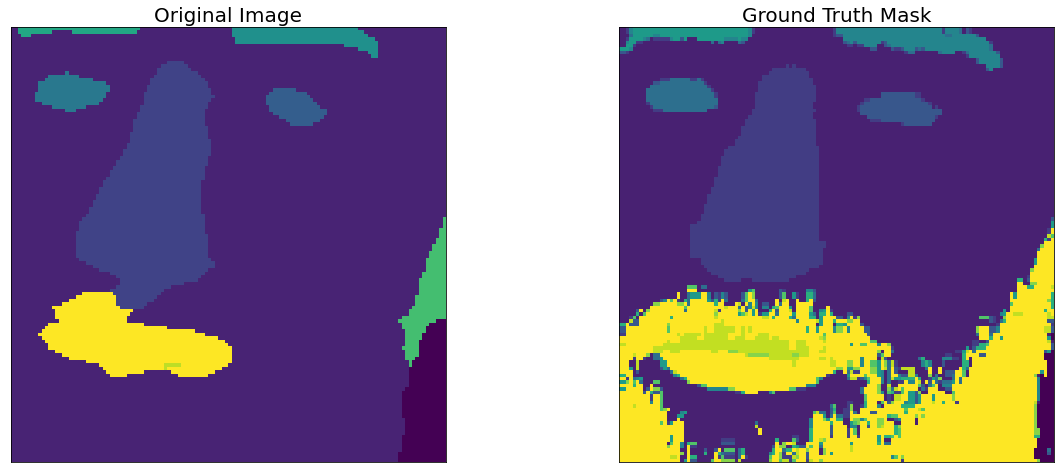

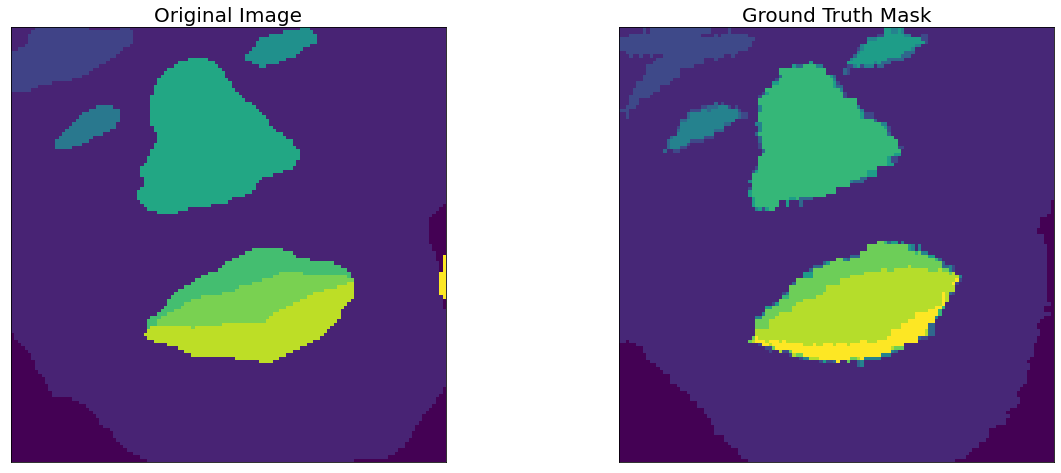

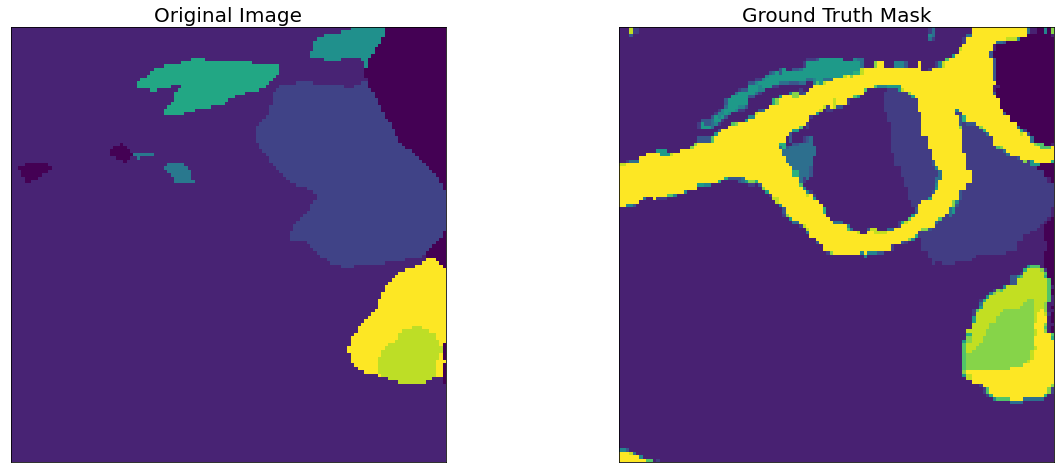

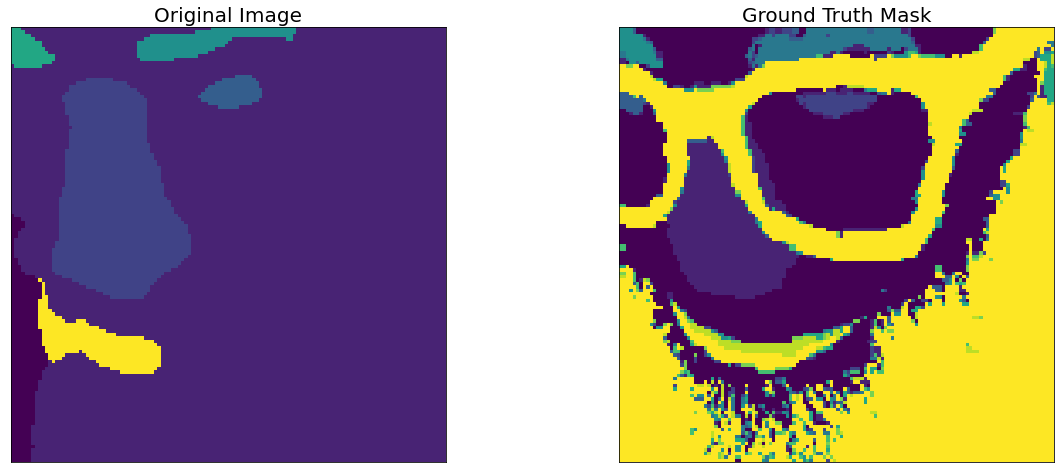

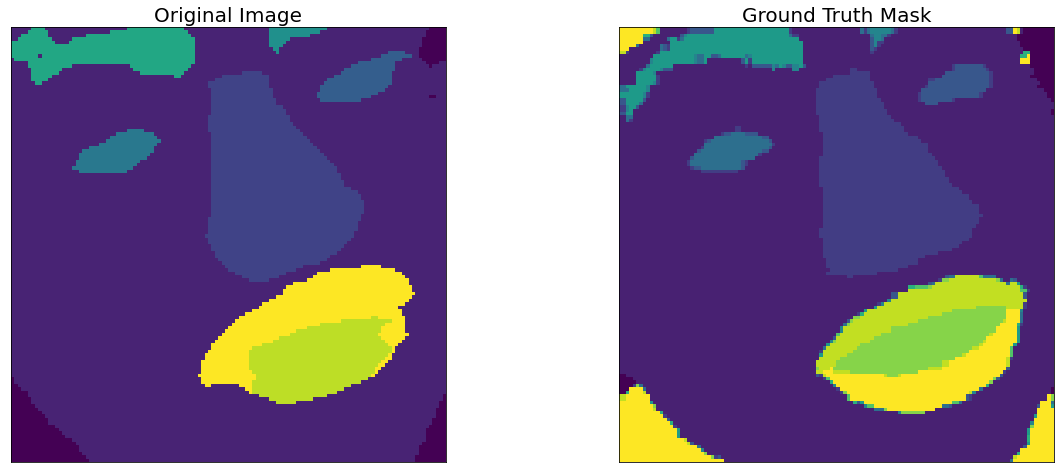

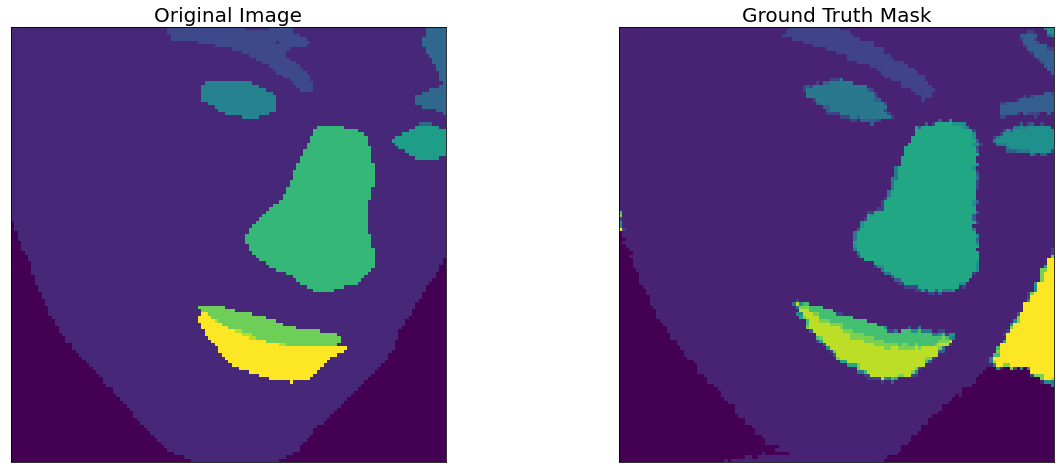

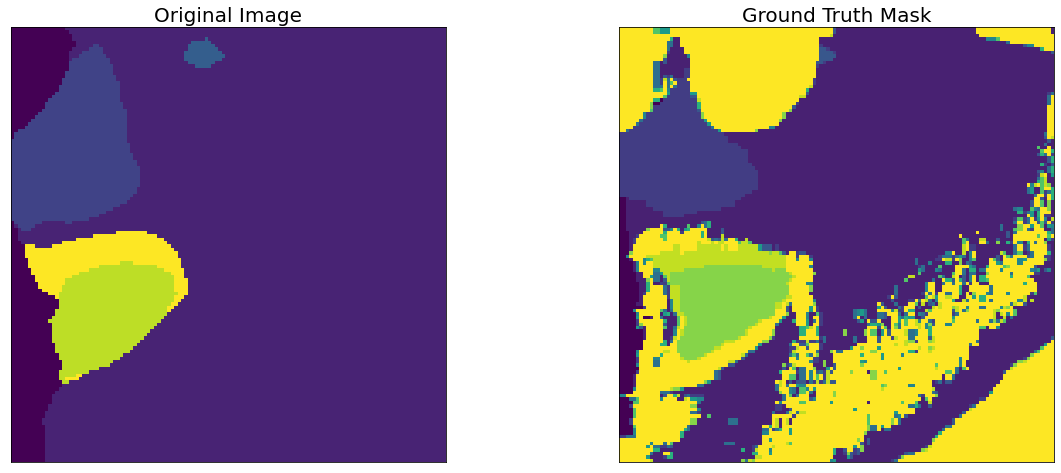

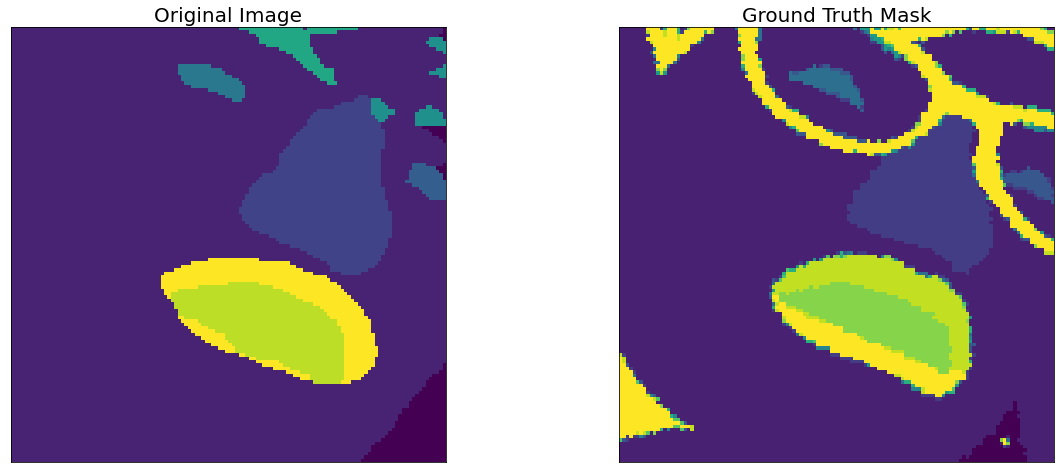

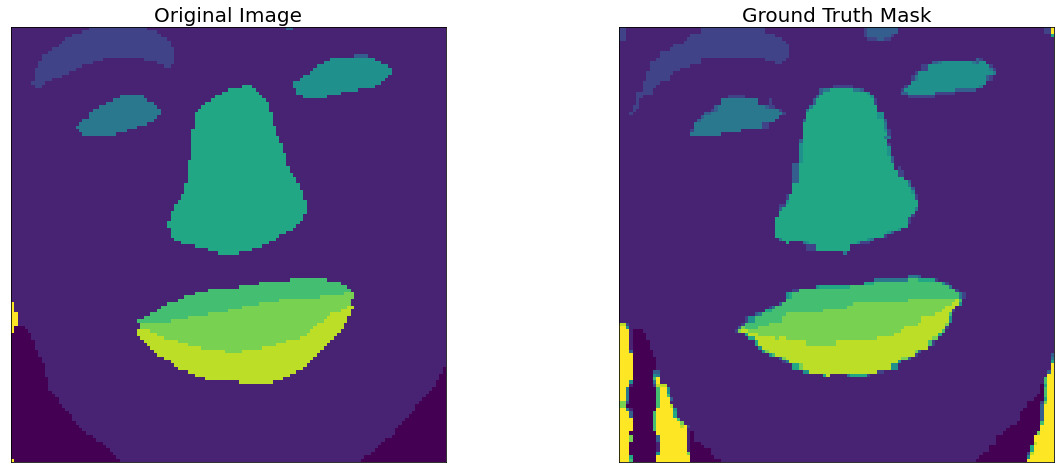

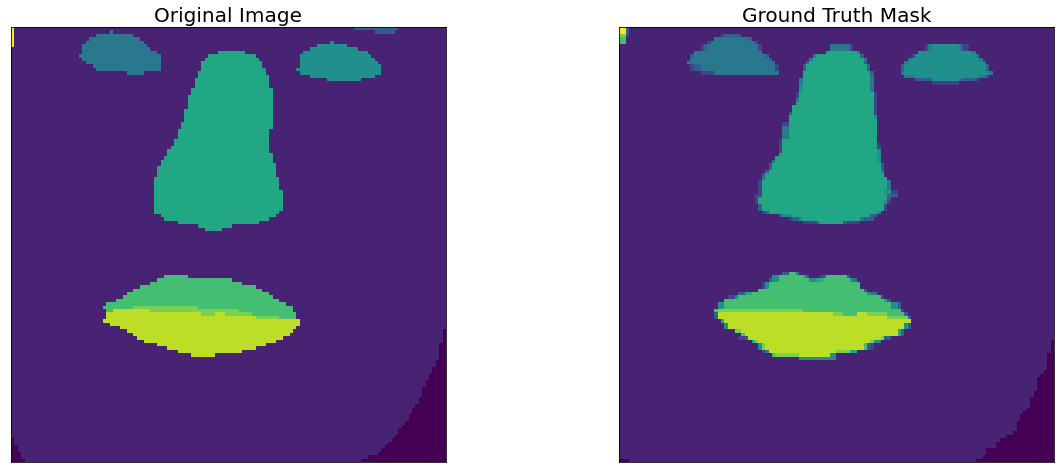

In [36]:
for x in range(10):
  visualize(
      original_image =  reverse_one_hot(x_train2[x]),
      ground_truth_mask = reverse_one_hot(y_train2[x]),
      #one_hot_encoded_mask = reverse_one_hot(y_test[x])
  )


## create our datasets

In [37]:
import torchvision.transforms as T
import torchvision.transforms.functional as F
import random

class MyDataSet(torch.utils.data.Dataset):
  def __init__(self, x, y):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    self._x, self._y = x,y

  def __len__(self):
    # a DataSet must know it size
    return self._x.shape[0]

  def __getitem__(self, index):
    x = torch.tensor(np.expand_dims(colour_code_segmentation(reverse_one_hot(torch.tensor(self._x[index, :])), rgb_vals),0).astype(float)).to(device="cuda", dtype=torch.float)
    y = self._y[index, :]
    # print("GETTING ITEM")
    return x, y

train_ds2 = MyDataSet(x_train2, y_train2)
val_ds2 = MyDataSet(x_test2, y_test2)


### Data Loader

In [38]:
from torch.utils.data import DataLoader

# Get train and val data loaders
train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True)
valid_loader2 = DataLoader(val_ds2, batch_size=20, shuffle=False)

In [39]:
print(len(train_loader2))

20


In [40]:
label_adapter = smp.Unet(
    in_channels=1,
    encoder_name=ENCODER, 
    encoder_weights="imagenet", 
    classes=num_classes, 
    activation=ACTIVATION,
    #encoder_depth = 18,
    #decoder_channels = 18,
    decoder_use_batchnorm = True,
    #aux_params=aux_params
)
#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Epoch: 1
train:   0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-37-1d7294a8c16e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(np.expand_dims(colour_code_segmentation(reverse_one_hot(torch.tensor(self._x[index, :])), rgb_vals),0).astype(float)).to(device="cuda", dtype=torch.float)


valid: 100%|██████████| 16/16 [00:00<00:00, 20.00it/s, cross_entropy_loss - 1.057, iou_score - 0.3915]
Model saved!

Epoch: 2
valid: 100%|██████████| 16/16 [00:00<00:00, 20.08it/s, cross_entropy_loss - 0.9646, iou_score - 0.5273]
Model saved!


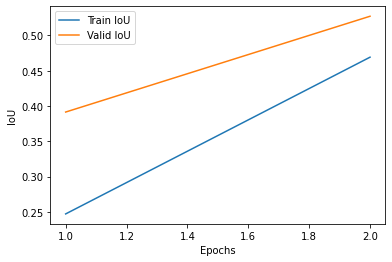


Epoch: 3
valid: 100%|██████████| 16/16 [00:00<00:00, 21.11it/s, cross_entropy_loss - 0.9322, iou_score - 0.5652]
Model saved!

Epoch: 4
valid: 100%|██████████| 16/16 [00:00<00:00, 20.94it/s, cross_entropy_loss - 0.9271, iou_score - 0.6156]
Model saved!


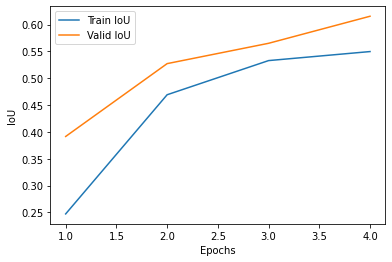


Epoch: 5
valid: 100%|██████████| 16/16 [00:00<00:00, 19.77it/s, cross_entropy_loss - 0.9085, iou_score - 0.6434]
Model saved!

Epoch: 6
valid: 100%|██████████| 16/16 [00:00<00:00, 21.15it/s, cross_entropy_loss - 0.9024, iou_score - 0.6423]


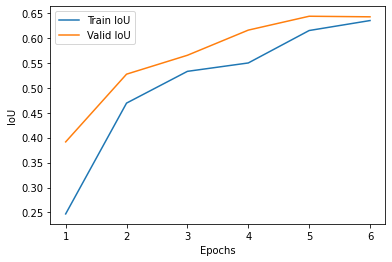


Epoch: 7
valid: 100%|██████████| 16/16 [00:00<00:00, 19.26it/s, cross_entropy_loss - 0.8905, iou_score - 0.6808]
Model saved!

Epoch: 8
valid: 100%|██████████| 16/16 [00:00<00:00, 20.67it/s, cross_entropy_loss - 0.8867, iou_score - 0.6878]
Model saved!


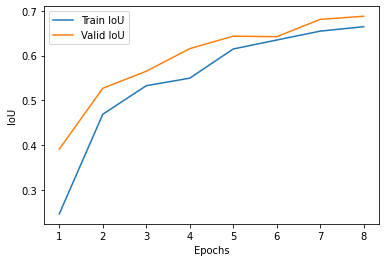


Epoch: 9
valid: 100%|██████████| 16/16 [00:00<00:00, 20.96it/s, cross_entropy_loss - 0.8851, iou_score - 0.6971]
Model saved!

Epoch: 10
valid: 100%|██████████| 16/16 [00:00<00:00, 20.87it/s, cross_entropy_loss - 0.8809, iou_score - 0.6958]


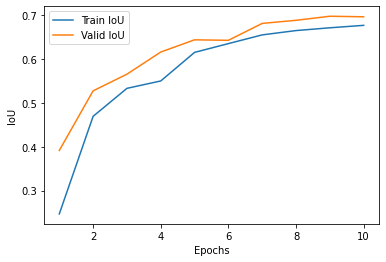


Epoch: 11
valid: 100%|██████████| 16/16 [00:00<00:00, 19.73it/s, cross_entropy_loss - 0.8801, iou_score - 0.6961]

Epoch: 12
valid: 100%|██████████| 16/16 [00:00<00:00, 19.83it/s, cross_entropy_loss - 0.8786, iou_score - 0.6964]


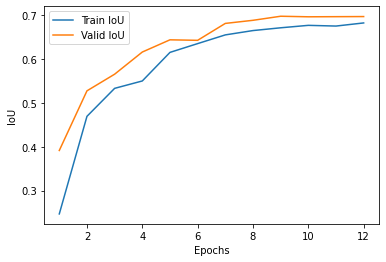


Epoch: 13
valid: 100%|██████████| 16/16 [00:00<00:00, 21.45it/s, cross_entropy_loss - 0.8776, iou_score - 0.7003]
Model saved!

Epoch: 14
valid: 100%|██████████| 16/16 [00:00<00:00, 21.18it/s, cross_entropy_loss - 0.8768, iou_score - 0.6991]


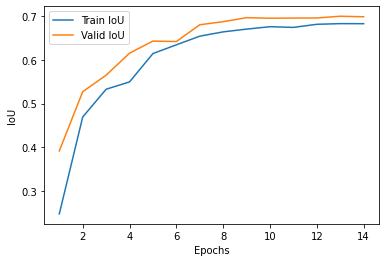


Epoch: 15
valid: 100%|██████████| 16/16 [00:00<00:00, 19.52it/s, cross_entropy_loss - 0.8762, iou_score - 0.7036]
Model saved!

Epoch: 16
valid: 100%|██████████| 16/16 [00:00<00:00, 19.94it/s, cross_entropy_loss - 0.8752, iou_score - 0.697]


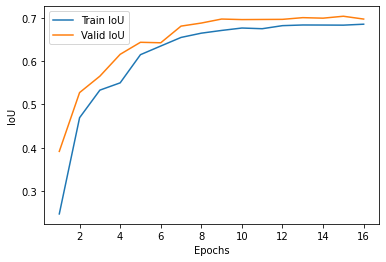


Epoch: 17
valid: 100%|██████████| 16/16 [00:00<00:00, 21.10it/s, cross_entropy_loss - 0.877, iou_score - 0.6997]

Epoch: 18
valid: 100%|██████████| 16/16 [00:00<00:00, 19.39it/s, cross_entropy_loss - 0.8742, iou_score - 0.6993]


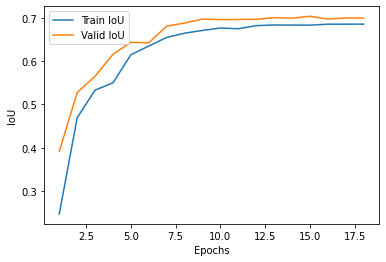


Epoch: 19
valid: 100%|██████████| 16/16 [00:00<00:00, 21.29it/s, cross_entropy_loss - 0.8785, iou_score - 0.6949]

Epoch: 20
train:   5%|▌         | 1/20 [00:00<00:04,  4.28it/s, cross_entropy_loss - 0.8619, iou_score - 0.6689]


KeyboardInterrupt: ignored

In [41]:
train_model(label_adapter, train_loader2, valid_loader2, "/content/drive/MyDrive/FRESH/label_adapter.pth", 100)

### Load and view model predictions

In [45]:
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image

def average(lst):
    return sum(lst) / len(lst)

def view_label_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image.cpu()
        image_vis = image.cpu()
        image_vis = np.transpose(image_vis,(1,2,0))
        #print("vis:",image_vis.shape)
        #print("im:",image.shape)
        
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        #print("X_TENSOR:", x_tensor, x_tensor.shape)
        # Predict test image
        pred_mask = model(x_tensor)
        #print("predraw", pred_mask.shape)
        #print("gtraw", gt_mask.shape)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        # Convert pred_mask from `CHW` format to `HWC` format
        #print(pred_mask.shape)
        # Get prediction channel corresponding to face
        pred_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        #print(pred_mask.shape)
        
        # Convert gt_mask from `CHW` format to `HWC` format
        #print(gt_mask.shape)
        gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)

        #gt_mask = scipy.signal.medfilt(gt_mask, 9)

        #Get f1
        #m = MultiLabelBinarizer().fit(gt_mask)
        #f1 = f1_score(m.transform(gt_mask), m.transform(pred_mask), average=None)
        #if len(f1) == num_classes:
        #  f1s.append(f1)

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(pred_mask), torch.tensor(gt_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan()
          #print(f1)
          f1s.append(np.array(f1))

        try:
          if idx < 20:
            visualize(
                original_image = image[0,::],
                ground_truth_mask = gt_mask,
                predicted_mask = pred_mask,
            )
        except:
          if idx < 20:
            visualize(
                original_image = image.cuda()[0,::],
                ground_truth_mask = gt_mask.cuda(),
                predicted_mask = pred_mask.cuda(),
            )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

<ipython-input-37-1d7294a8c16e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(np.expand_dims(colour_code_segmentation(reverse_one_hot(torch.tensor(self._x[index, :])), rgb_vals),0).astype(float)).to(device="cuda", dtype=torch.float)
<ipython-input-45-668078d6a306>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
<ipython-input-45-668078d6a306>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask

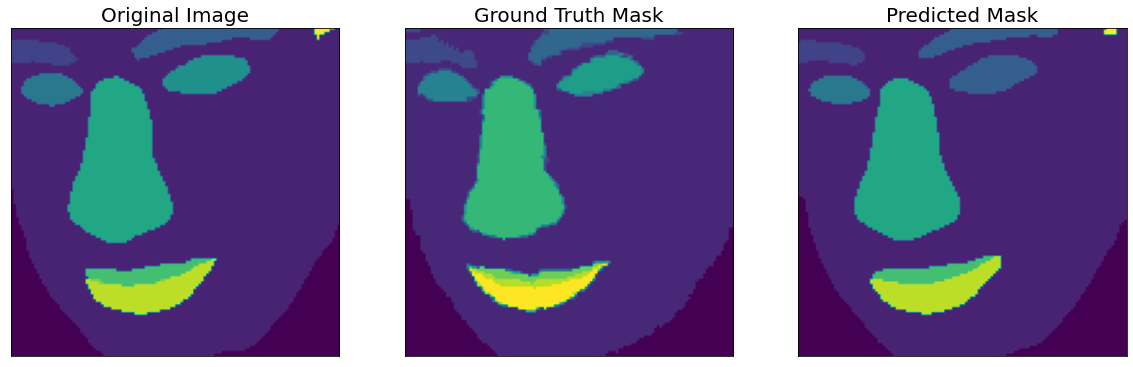

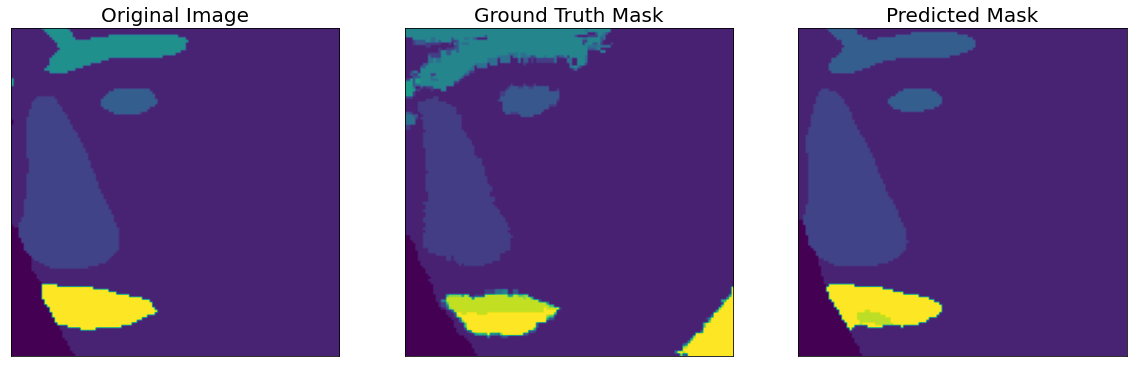

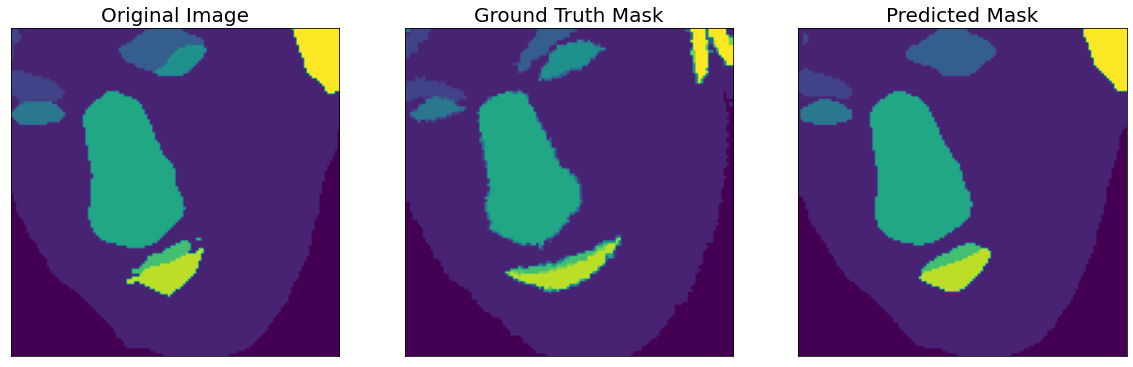

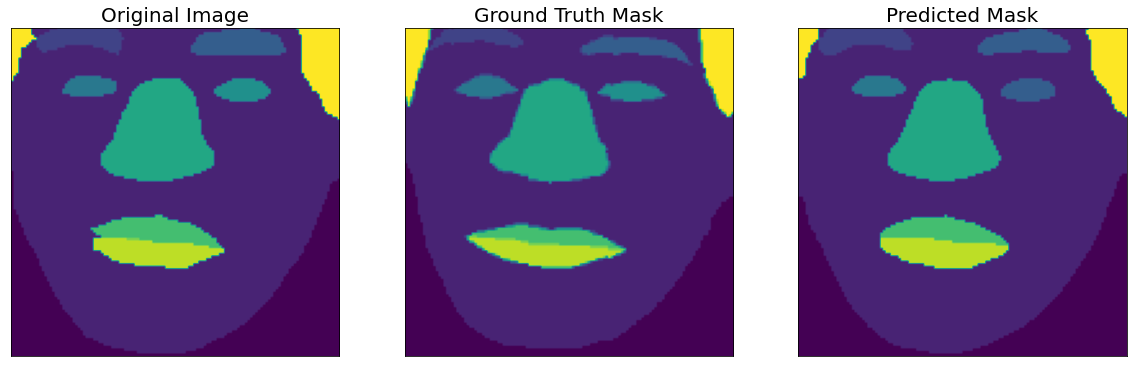

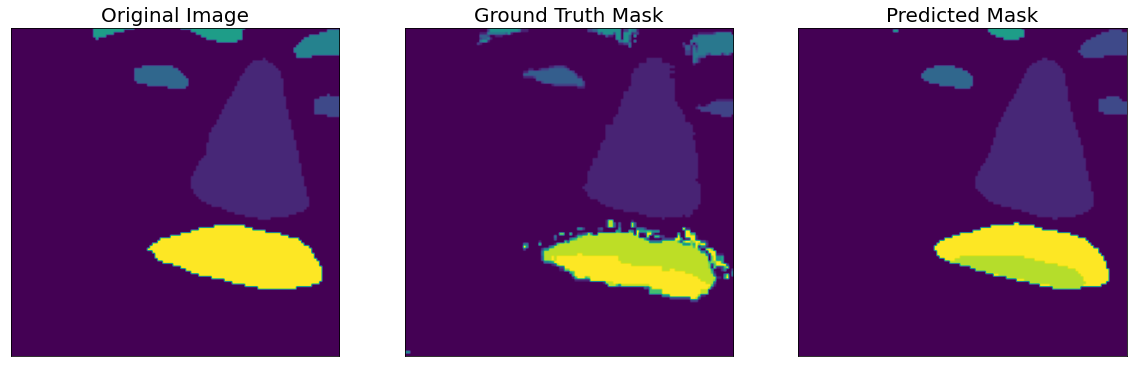

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fa36d2ce5e0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


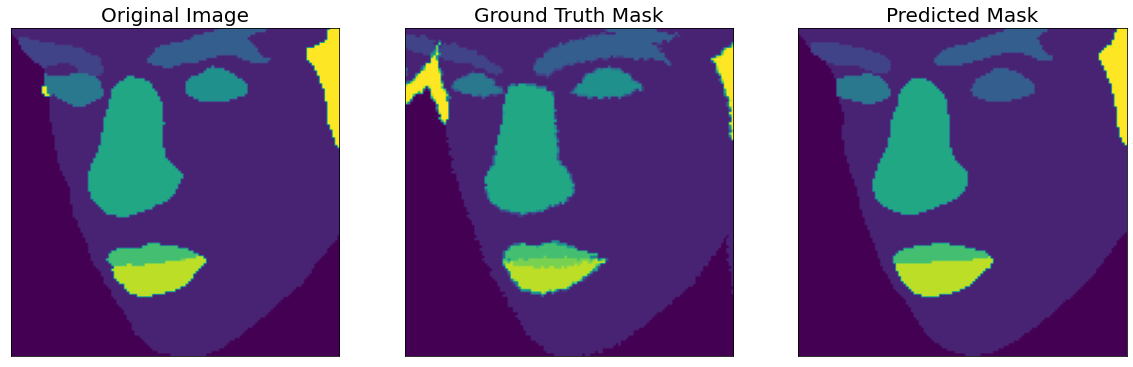

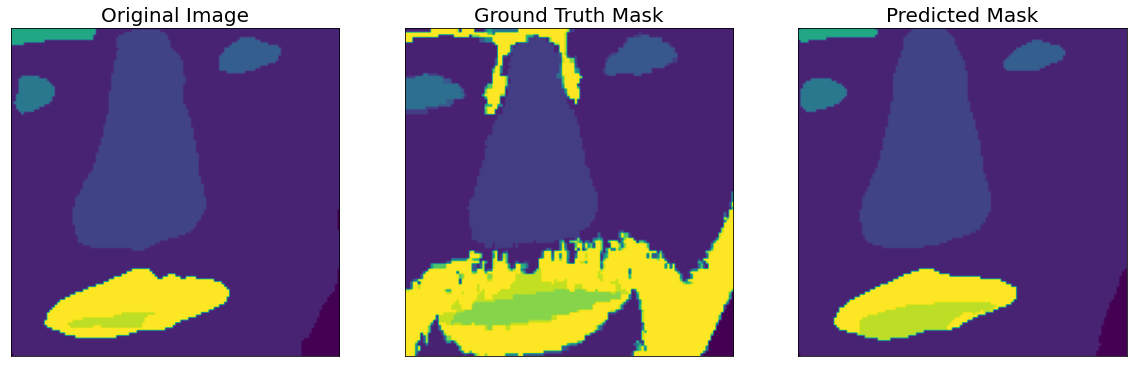

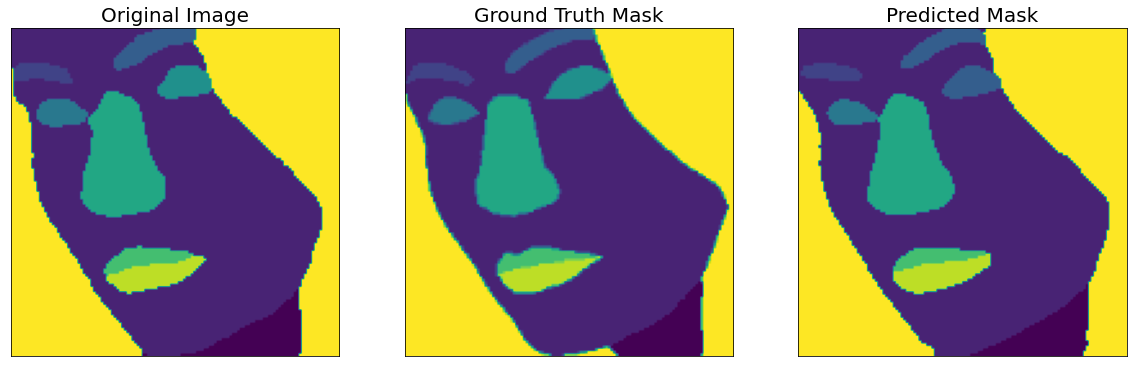

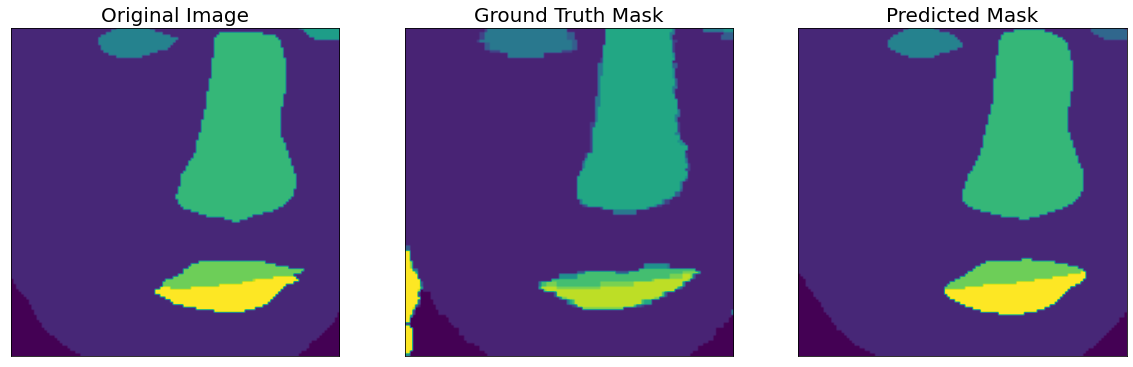

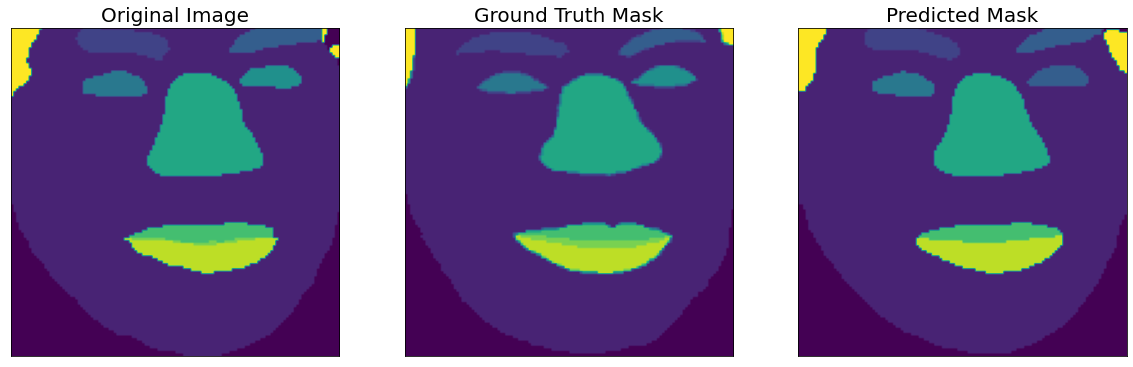

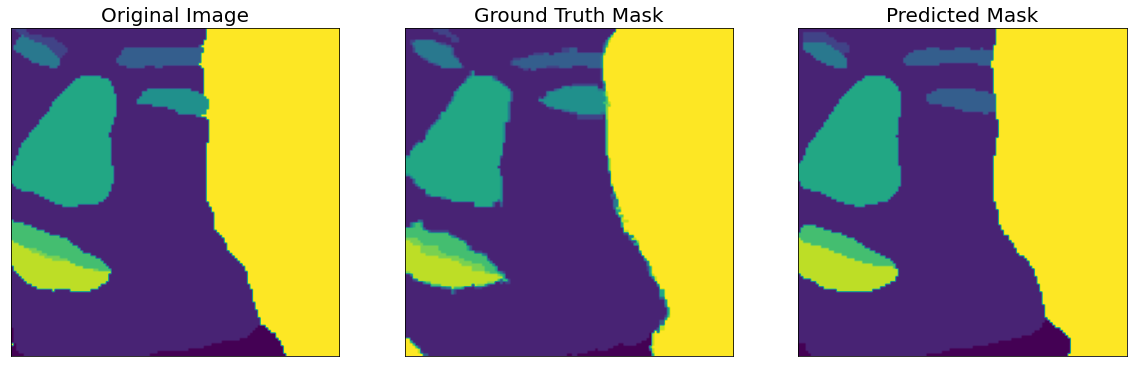

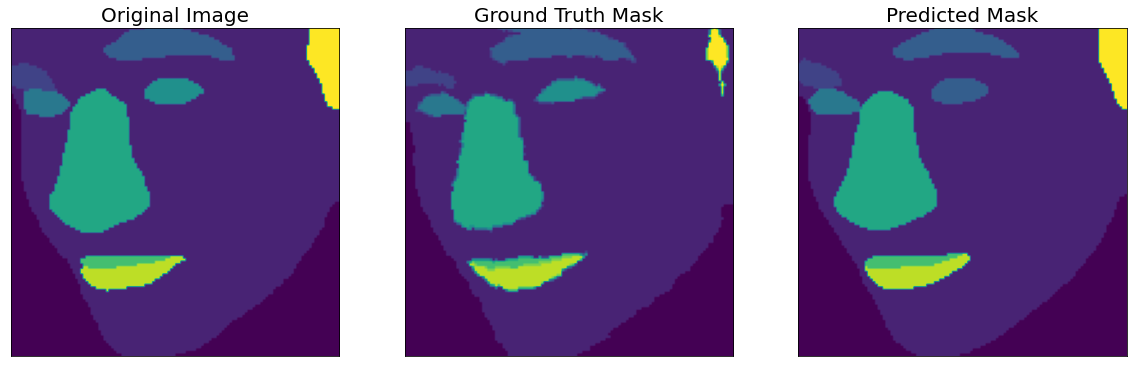

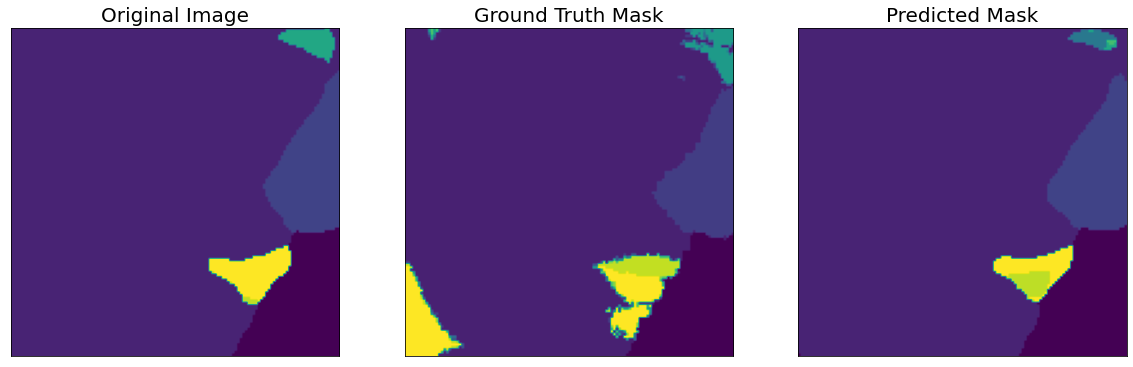

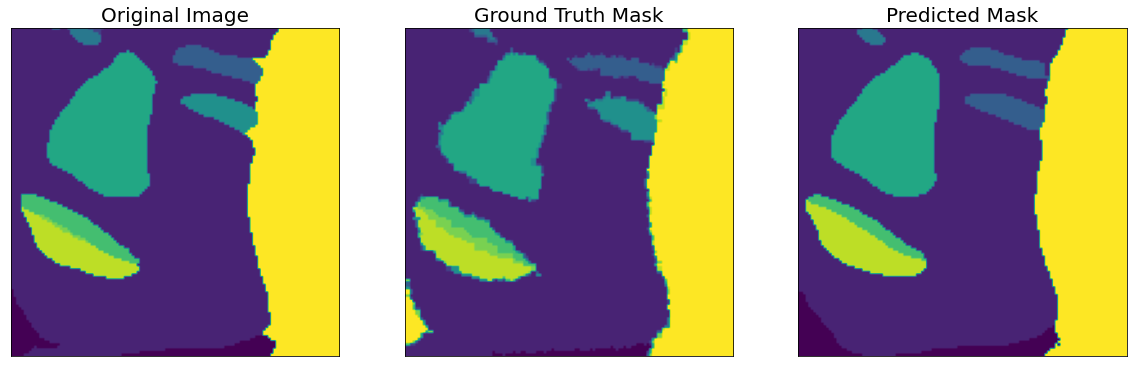

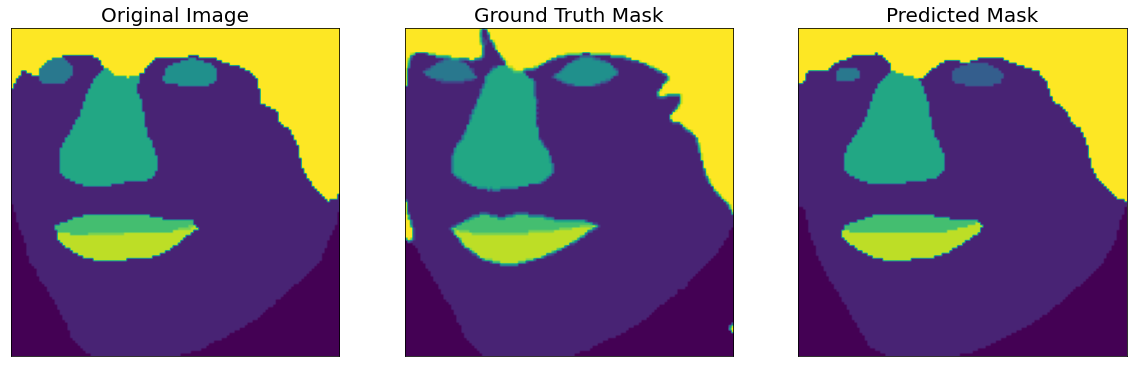

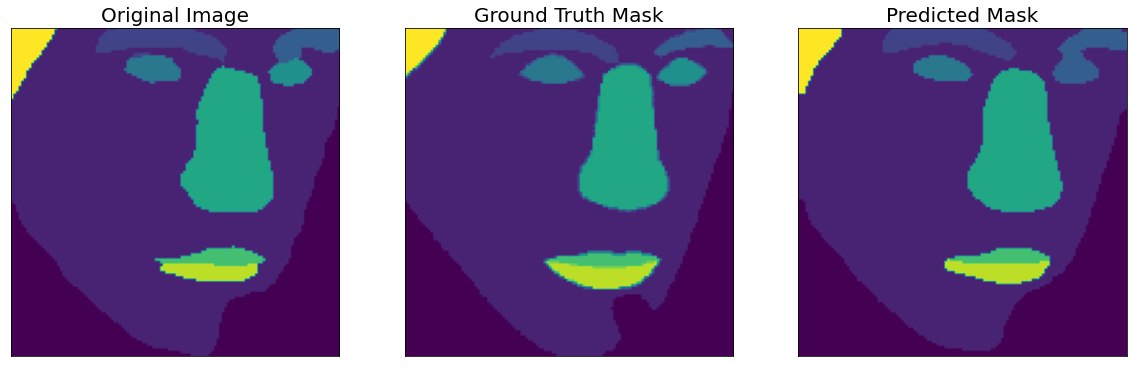

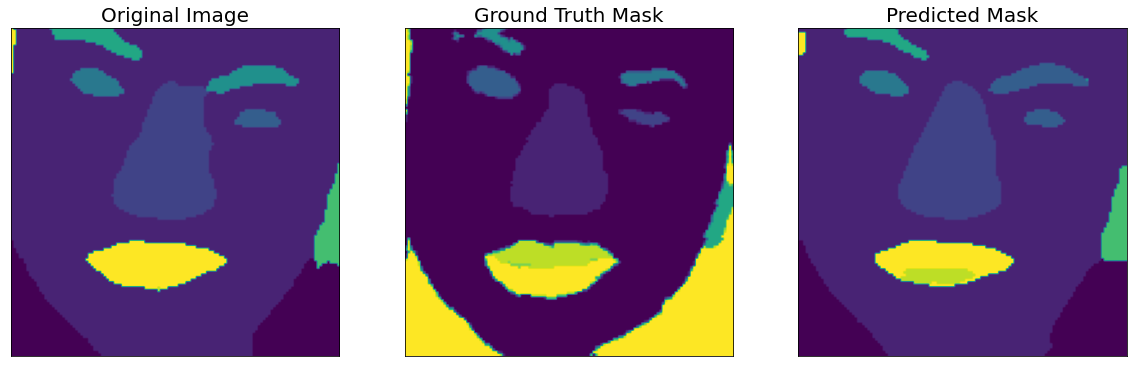

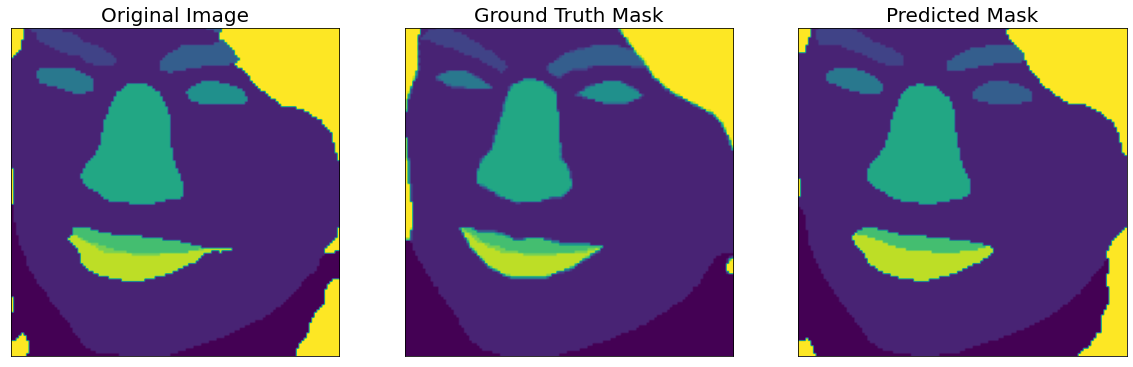

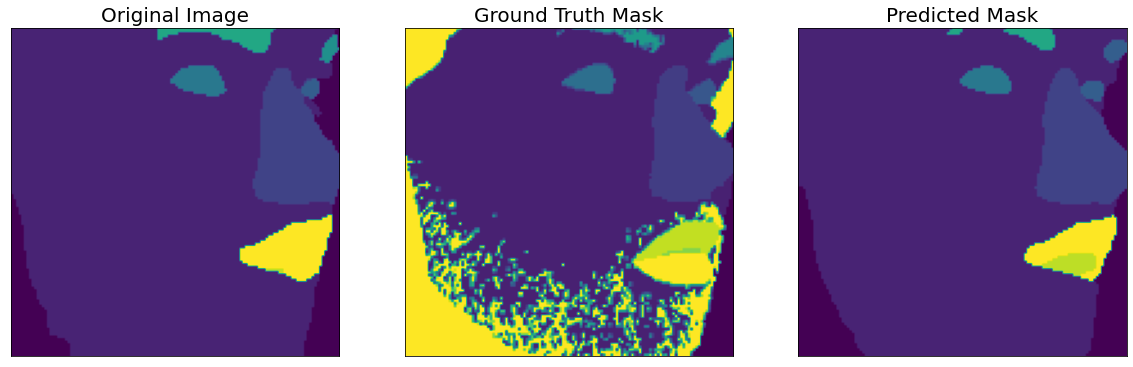

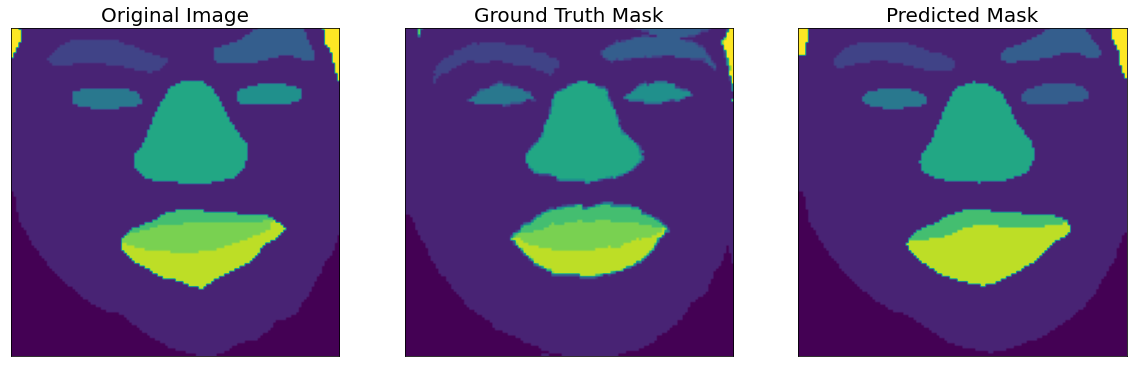

Dataset MIoU =  0.38318799568805845
Dataset F1 =  [0.682325   0.9229296  0.72167885 0.435602   0.5985461  0.40000105
 0.6896683  0.57075316 0.40000105 0.6053836  0.6410109  0.40000105]
Dataset F1 av =  0.5889917


In [46]:
model = torch.load("/content/drive/MyDrive/FRESH/label_adapter.pth", map_location=DEVICE)

view_label_predictions(model,val_ds2, num_classes)